In [ ]:
# !pip install pretrainedmodels==0.7.4
# !pip install efficientnet-pytorch==0.6.3
# !pip install timm==0.3.2

In [1]:
!nvidia-smi

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import SimpleITK as sitk
import cv2
from tqdm import tqdm

import sys
sys.path.append(os.path.abspath('/workspace/sunggu'))
sys.path.append(os.path.abspath('/workspace/sunggu/4.Dose_img2img'))
sys.path.append(os.path.abspath('/workspace/sunggu/MONAI'))
from sunggu_utils import check_value, take_list, plot_confusion_matrix, list_sort_nicely, find_dir, plot_3D

Fri Jan 29 06:10:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:02:00.0 Off |                  N/A |
| 89%   87C    P2   225W / 280W |  17062MiB / 24220MiB |     93%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  TITAN RTX           Off  | 00000000:03:00.0 Off |                  N/A |
|100%   

In [2]:
torch.__version__

'1.6.0'

## Setup imports

In [3]:
import glob
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import torch
import skimage
import monai

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, Dataset
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss, GeneralizedDiceLoss, FocalLoss, TverskyLoss, NoiseRobustDiceLoss
from monai.metrics import compute_meandice, DiceMetric, ConfusionMatrixMetric 
from monai.networks.layers import Norm
from monai.networks.nets import UNet, highresnet
from monai.transforms import (
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadNiftid,
    LoadNumpyd,
    Orientationd,
    ScaleIntensityRanged,
    Spacingd,
    Lambdad,
    ToTensord,
    CastToTyped,
    DeleteItemsd,
    AsDiscrete,
    SpatialPadd,
    CenterSpatialCropd,
    RandSpatialCropd,
    Resized,
)
from monai.utils import first, set_determinism

print_config()

MONAI version: 0+unknown
Python version: 3.6.9 (default, Jul 17 2020, 12:50:27)  [GCC 8.4.0]
OS version: Linux (4.4.0-198-generic)
Numpy version: 1.18.5
Pytorch version: 1.6.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.0
scikit-image version: 0.17.2
Pillow version: 8.0.1
Tensorboard version: 2.3.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.7.0
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.50.2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Set 시드

In [4]:
import random

random_seed = 7
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

set_determinism(seed=7)

## Set Train / Test

In [6]:
train_low_images = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/sinogram_dataset/2D_dataset/Train/noise50_b40f_3.0/*/*.npy'))
train_high_images = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/sinogram_dataset/2D_dataset/Train/noise100_b40f_3.0/*/*.npy'))

valid_low_images = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/sinogram_dataset/2D_dataset/Valid/noise50_b40f_3.0/*/*.npy'))
valid_high_images = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/sinogram_dataset/2D_dataset/Valid/noise100_b40f_3.0/*/*.npy'))


train_files = [{"low": low_name, "high": high_name} for low_name, high_name in zip(train_low_images, train_high_images)]
valid_files = [{"low": low_name, "high": high_name} for low_name, high_name in zip(valid_low_images, valid_high_images)]

## Augmentation

In [7]:
# CT에 맞는 Augmentation
from torchvision import transforms
train_transforms = Compose(
    [
        LoadNumpyd(keys=["low", "high"]),
        AddChanneld(keys=["low", "high"]), 
        Resized(keys=["low", "high"], spatial_size=(572, 572), mode='bilinear', align_corners=True),
        RandSpatialCropd(keys=["low", "high"], roi_size=(512, 512), random_center=False, random_size=False),
        ToTensord(keys=["low", "high"]),
        Lambdad(keys=["low", "high"], func=transforms.Normalize(mean=(0.5), std=(0.5))),
    ]
)



valid_transforms = Compose(
    [
        LoadNumpyd(keys=["low", "high"]),
        AddChanneld(keys=["low", "high"]), 
        Resized(keys=["low", "high"], spatial_size=(572, 572), mode='bilinear', align_corners=True),
        RandSpatialCropd(keys=["low", "high"], roi_size=(512, 512), random_center=False, random_size=False),
        ToTensord(keys=["low", "high"]),
        Lambdad(keys=["low", "high"], func=transforms.Normalize(mean=(0.5), std=(0.5))),
    ]
)

## Check transforms in DataLoader

/workspace/sunggu/4.Dose_img2img/dataset/sinogram_dataset/2D_dataset/Train/noise50_b40f_3.0/CHU_SOO_SEO_F65/CHU_SOO_SEO_F65_001_20201125_135633_00011.npy
/workspace/sunggu/4.Dose_img2img/dataset/sinogram_dataset/2D_dataset/Train/noise100_b40f_3.0/CHU_SOO_SEO_F65/CHU_SOO_SEO_F65_001_20201125_123915_00011.npy
image shape: torch.Size([512, 512])


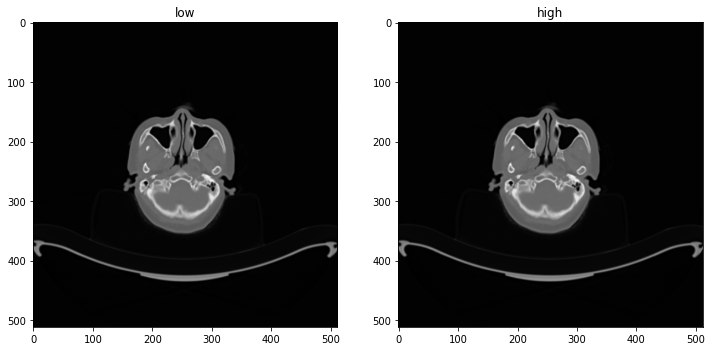

In [8]:
check_ds = Dataset(data=train_files, transform=train_transforms)
# check_loader = DataLoader(check_ds, batch_size=1, shuffle=False)
# check_data = next(iter(check_loader))

check_data = check_ds[300]

print(check_data['low_meta_dict']['filename_or_obj'])
print(check_data['high_meta_dict']['filename_or_obj'])

low = (check_data["low"][0])
high = (check_data["high"][0])
print(f"image shape: {low.shape}")

plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("low")
plt.imshow(low, cmap="gray")

plt.subplot(1, 2, 2)
plt.title("high")
plt.imshow(high, cmap="gray")

plt.show()

In [9]:
import multiprocessing
# from torchsampler.imbalanced import ImbalancedDatasetSampler, sunggu_ImbalancedDatasetSampler

# cf) use batch_size=2 to load images and use RandCropByPosNegLabeld
print("CPU 갯수 = ", multiprocessing.cpu_count())

# Cachedataset 이거 뭔가 문제가 있음...
train_ds = Dataset(data=train_files, transform=train_transforms)
# train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=0.5)
train_loader = DataLoader(train_ds, batch_size=10, shuffle=True, num_workers=12, drop_last=True)

valid_ds = Dataset(data=valid_files, transform=valid_transforms)
# train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=0.5)
valid_loader = DataLoader(valid_ds, batch_size=1, shuffle=False, num_workers=12, drop_last=False)

CPU 갯수 =  12


## Create Model, Loss, Optimizer  Only Low -> High

In [ ]:
# def lambda_rule(epoch):
#     lr_l = 1.0 - max(0, epoch + 1 - 100) / float(100 + 1)
#     return lr_l

# scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_rule)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, threshold=0.01, patience=5)
# scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=0)

In [ ]:
# if (epoch + 1) > params.decay_epoch:
#     D_A_optimizer.param_groups[0]['lr'] -= params.lrD / (params.num_epochs - params.decay_epoch)
#     D_B_optimizer.param_groups[0]['lr'] -= params.lrD / (params.num_epochs - params.decay_epoch)
#     G_optimizer.param_groups[0]['lr'] -= params.lrG / (params.num_epochs - params.decay_epoch)

In [10]:
def init_net_multi_gpu(net, init_type='normal', init_gain=0.02):
    net = torch.nn.DataParallel(net)
    net.to('cuda')        
    init_weights(net, init_type, init_gain=init_gain)
    return net

def init_net_sigle_gpu(net, init_type='normal', init_gain=0.02):
    net.to('cuda')        
    init_weights(net, init_type, init_gain=init_gain)
    return net

In [11]:
from Pix2Pix_sunggu.model import *
from Pix2Pix_sunggu.util import *

device = 'cuda'

# 모델
netG = Pix2Pix(in_channels=1, out_channels=1, feature=64, norm='inorm').to(device)

netD = Discriminator(in_channels=2, out_channels=1, feature=64, norm='inorm').to(device)


# multi-gpu 사용
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    netG  = init_net_multi_gpu(netG, init_type='normal', init_gain=0.02)
    netD  = init_net_multi_gpu(netD, init_type='normal', init_gain=0.02)

else :
    netG  = init_net_sigle_gpu(netG, init_type='normal', init_gain=0.02)
    netD  = init_net_sigle_gpu(netD, init_type='normal', init_gain=0.02)


initialize network with normal
initialize network with normal


In [ ]:
# from torchsummary import summary
# input_size = (1,32,320,320)
# summary(model.encoder, input_size, batch_size=-1, device='cpu')

## 모델 이어서 학습하기

In [ ]:
## 네트워크 불러오기
checkpoint_dir = '/workspace/sunggu/4.Dose_img2img/model/OT_Cycle_Gan_2D_sinogram/epoch_55_model.pth'
checkpoint = torch.load(checkpoint_dir)

epoch = checkpoint['epoch']

netG.load_state_dict(checkpoint['netG_low_2_high_state_dict'])
netD.load_state_dict(checkpoint['netD_low_state_dict'])


## multi-gpu 사용
if torch.cuda.device_count() > 1:
    netG = torch.nn.DataParallel(netG)
    netD = torch.nn.DataParallel(netD)
    
    
netG.to('cuda')  
netD.to('cuda')  


In [12]:
# 손실함수 정의하기
L1_loss  = nn.L1Loss()
gan_loss = nn.BCELoss()

# Optimizer 설정하기
optimizer_G = torch.optim.Adam(netG.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(netD.parameters(), lr=2e-4, betas=(0.5, 0.999))

scheduler_G = torch.optim.lr_scheduler.StepLR(optimizer_G, step_size=10, gamma=0.7)
scheduler_D = torch.optim.lr_scheduler.StepLR(optimizer_D, step_size=10, gamma=0.7)


In [ ]:
optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])

scheduler_G.load_state_dict(checkpoint['scheduler_G'])        
scheduler_D.load_state_dict(checkpoint['scheduler_D'])      

###### 필요한 Weight만 Load

In [ ]:
# # Before
# model_dict = model.state_dict()
# print("이전 weight = ", model_dict['encoder._conv_stem.weight'][0])

# load_dir = '/workspace/sunggu/1.Hemorrhage/monai_experiment/model/Efficient3d_conv2d_Aux/'
# pretrained_dict =  torch.load(os.path.join(load_dir, "epoch_0_best_metric_model.pth")) 

# # 1. filter out unnecessary keys
# pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
# # 2. overwrite entries in the existing state dict
# model_dict.update(pretrained_dict) 
# # 3. load the new state dict
# model.load_state_dict(model_dict)

# # After
# print("이후 weight = ", model_dict['encoder._conv_stem.weight'][0])

## Train

In [13]:
## 그밖에 부수적인 functions 설정하기
fn_tonumpy = lambda x: x.cpu().detach().numpy().transpose(0, 2, 3, 1)
fn_denorm = lambda x: (x * 0.5) + 0.5

In [15]:
from torch.utils.tensorboard import SummaryWriter
from monai.visualize import plot_2d_or_3d_image

## 네트워크 학습시키기
st_epoch = 0

epoch_num = 1000
val_interval = 10

epoch_train_loss_list = list()
epoch_val_loss_list = list()

epoch_train_metric_list = list()
epoch_val_metric_list = list()

writer = SummaryWriter(log_dir='/workspace/sunggu/4.Dose_img2img/runs/Pix2Pix_2D_sinogram')
root_dir = '/workspace/sunggu/4.Dose_img2img/model/Pix2Pix_2D_sinogram/'

low2high_png_dir = '/workspace/sunggu/4.Dose_img2img/Predictions/png/'+'Pix2Pix_2D_sinogram'+'/low2high/'

# 모델 save폴더 만들기
os.makedirs(root_dir, mode=0o777, exist_ok=True)
os.makedirs(low2high_png_dir, mode=0o777, exist_ok=True)

    
for epoch in range(epoch_num):
    print("-" * 10)
    print(f"epoch {epoch}/{epoch_num}")
    
    # Model 선언
    netG.train()    
    netD.train()
    
    # Loss 선언
    loss_G_gan_train = []
    loss_G_L1_train  = []
    loss_D_real_train = []
    loss_D_fake_train = []

    
    train_iterator = tqdm(train_loader, desc='Train', file=sys.stdout)    
    for batch_data in train_iterator:
        
        input_low  = batch_data['low'].to(device)
        input_high = batch_data['high'].to(device)
        
        output = netG(input_low)
        real = torch.cat([input_low, input_high], dim=1)
        fake = torch.cat([input_low, output], dim=1)        
        
        # Train Discriminator
        set_requires_grad(netD, True)
        optimizer_D.zero_grad()
        
        pred_real = netD(real)        
        pred_fake = netD(fake.detach())
        
        
        loss_D_real = gan_loss(pred_real, torch.ones_like(pred_real))
        loss_D_fake = gan_loss(pred_fake, torch.zeros_like(pred_fake))
        loss_D      = 0.5 * (loss_D_real + loss_D_fake)
        
        loss_D.backward()
        optimizer_D.step()
        
        # Train Generator        
        set_requires_grad(netD, False)
        optimizer_G.zero_grad()
        
        pred_fake = netD(fake)        
             
        loss_G_gan = gan_loss(pred_fake, torch.ones_like(pred_fake))
        loss_G_L1  = L1_loss(output, input_high)
        
        loss_G     = loss_G_gan + 100.0*loss_G_L1
        
        loss_G.backward()
        optimizer_G.step()
        
        # 기록
        loss_D_real_train += [loss_D_real.item()]
        loss_D_fake_train += [loss_D_fake.item()]
        loss_G_gan_train  += [loss_G_gan.item()]
        loss_G_L1_train   += [loss_G_L1.item()]

        
    print( "Generator Loss       [Gan Loss]    = %.4f" %np.mean(loss_G_gan_train) ) 
    print( "Generator Loss       [L1  Loss]    = %.4f" %np.mean(loss_G_L1_train) ) 
    print( "Discriminator Loss   [Real]        = %.4f" %np.mean(loss_D_real_train) )
    print( "Discriminator Loss   [Fake]        = %.4f" %np.mean(loss_D_fake_train) )
    
    
    # Tensorboard 저장하기
    input_low   = fn_denorm(fn_tonumpy((input_low)))
    input_high  = fn_denorm(fn_tonumpy((input_high)))
    output      = fn_denorm(fn_tonumpy((output)))

    input_low   = np.clip(input_low, a_min=0, a_max=1)
    input_high  = np.clip(input_high, a_min=0, a_max=1)
    output      = np.clip(output, a_min=0, a_max=1)

    # png Save
    plt.imsave(low2high_png_dir+'epoch_'+str(epoch)+'_input_low.png',   input_low[0].squeeze(),   cmap="gray")
    plt.imsave(low2high_png_dir+'epoch_'+str(epoch)+'_output_high.png', output[0].squeeze(),      cmap="gray")
    plt.imsave(low2high_png_dir+'epoch_'+str(epoch)+'_ground_high.png', input_high[0].squeeze(),  cmap="gray")
    
    # Loss Write    
    writer.add_scalar('Train/loss_G_gan',  np.mean(loss_G_gan_train), epoch)
    writer.add_scalar('Train/loss_G_L1',   np.mean(loss_G_L1_train), epoch)
    writer.add_scalar('Train/loss_D_real', np.mean(loss_D_real_train), epoch)
    writer.add_scalar('Train/loss_D_fake', np.mean(loss_D_fake_train), epoch)    
    
    
    with torch.no_grad():
        netG.eval()
        netD.eval()

        loss_G_gan_valid  = []
        loss_G_L1_valid   = []
        loss_D_real_valid = []
        loss_D_fake_valid = []
        
        valid_iterator = tqdm(valid_loader, desc='Valid', file=sys.stdout)    
        for batch_data in valid_iterator:
        
            input_low  = batch_data['low'].to(device)
            input_high = batch_data['high'].to(device)
            
            output = netG(input_low)

            real = torch.cat([input_low, input_high], dim=1)
            fake = torch.cat([input_low, output], dim=1)      
            
            # D
            pred_real = netD(real)        
            pred_fake = netD(fake.detach())

            loss_D_real = gan_loss(pred_real, torch.ones_like(pred_real))
            loss_D_fake = gan_loss(pred_fake, torch.zeros_like(pred_fake))

            # G
            pred_fake = netD(fake)        
            
            loss_G_gan = gan_loss(pred_fake, torch.ones_like(pred_fake))
            loss_G_L1  = L1_loss(output, input_high)

            # 기록
            loss_D_real_valid += [loss_D_real.item()]
            loss_D_fake_valid += [loss_D_fake.item()]
            loss_G_gan_valid  += [loss_G_gan.item()]
            loss_G_L1_valid   += [loss_G_L1.item()]
        
        
    print( "Generator Loss       [Gan Loss]    = %.4f" %np.mean(loss_G_gan_valid) ) 
    print( "Generator Loss       [L1  Loss]    = %.4f" %np.mean(loss_G_L1_valid) ) 
    print( "Discriminator Loss   [Real]        = %.4f" %np.mean(loss_D_real_valid) )
    print( "Discriminator Loss   [Fake]        = %.4f" %np.mean(loss_D_fake_valid) )

    
    # Tensorboard 저장하기
    input_low   = fn_denorm(fn_tonumpy((input_low)))
    input_high  = fn_denorm(fn_tonumpy((input_high)))
    output = fn_denorm(fn_tonumpy((output)))

    input_low   = np.clip(input_low, a_min=0, a_max=1)
    input_high  = np.clip(input_high, a_min=0, a_max=1)
    output = np.clip(output, a_min=0, a_max=1)

    # png Save
    plt.imsave(low2high_png_dir+'epoch_'+str(epoch)+'_input_low.png',   input_low[0].squeeze(),   cmap="gray")
    plt.imsave(low2high_png_dir+'epoch_'+str(epoch)+'_output_high.png', output[0].squeeze(), cmap="gray")
    plt.imsave(low2high_png_dir+'epoch_'+str(epoch)+'_ground_high.png', input_high[0].squeeze(),  cmap="gray")
    
    # Loss Write    
    writer.add_scalar('Valid/loss_G_gan',  np.mean(loss_G_gan_valid), epoch)
    writer.add_scalar('Valid/loss_G_L1',   np.mean(loss_G_L1_valid), epoch)
    writer.add_scalar('Valid/loss_D_real', np.mean(loss_D_real_valid), epoch)
    writer.add_scalar('Valid/loss_D_fake', np.mean(loss_D_fake_valid), epoch)

    
    # 저장
    if epoch % 5 == 0 or epoch == epoch_num:

        if torch.cuda.device_count() > 1:
            checkpoint = {'epoch': epoch, 
                          'netG_state_dict': netG.module.state_dict(), 
                          'netD_state_dict': netD.module.state_dict(), 
                          'optimizer_G_state_dict': optimizer_G.state_dict(),
                          'optimizer_D_state_dict': optimizer_D.state_dict(),  
                          'scheduler_G': scheduler_G.state_dict(),
                          'scheduler_D': scheduler_D.state_dict(),
                         }                    

        else:
            checkpoint = {'epoch': epoch, 
                          'netG_state_dict': netG.state_dict(), 
                          'netD_state_dict': netD.state_dict(), 
                          'optimizer_G_state_dict': optimizer_G.state_dict(),
                          'optimizer_D_state_dict': optimizer_D.state_dict(),
                          'scheduler_G': scheduler_G.state_dict(),
                          'scheduler_D': scheduler_D.state_dict(),
                         }                         

            torch.save(checkpoint, os.path.join(root_dir, "epoch_" + str(epoch) + "_model.pth"))        
    
    # Scheduler
    writer.add_scalar('lr', optimizer_G.param_groups[0]['lr'], epoch)      
    old_lr = optimizer_G.param_groups[0]['lr']
    lr = optimizer_G.param_groups[0]['lr']
    print('Learning Rate %.10f -> %.10f' % (old_lr, lr))

    scheduler_G.step()    
    scheduler_D.step()    

writer.close()

----------
epoch 0/1000
Train: 100%|██████████| 258/258 [02:00<00:00,  2.15it/s]
Generator Loss       [Gan Loss]    = 1.2772
Generator Loss       [L1  Loss]    = 0.0067
Discriminator Loss   [Real]        = 0.5610
Discriminator Loss   [Fake]        = 0.5603
Valid: 100%|██████████| 570/570 [00:24<00:00, 22.95it/s]
Generator Loss       [Gan Loss]    = 0.7553
Generator Loss       [L1  Loss]    = 0.0056
Discriminator Loss   [Real]        = 0.6478
Discriminator Loss   [Fake]        = 0.7110
Learning Rate 0.0002000000 -> 0.0002000000
----------
epoch 1/1000
Train: 100%|██████████| 258/258 [02:03<00:00,  2.09it/s]
Generator Loss       [Gan Loss]    = 2.1573
Generator Loss       [L1  Loss]    = 0.0063
Discriminator Loss   [Real]        = 0.3546
Discriminator Loss   [Fake]        = 0.3812
Valid: 100%|██████████| 570/570 [00:24<00:00, 23.58it/s]
Generator Loss       [Gan Loss]    = 4.2255
Generator Loss       [L1  Loss]    = 0.0078
Discriminator Loss   [Real]        = 0.0060
Discriminator Loss   

Valid: 100%|██████████| 570/570 [00:23<00:00, 24.08it/s]
Generator Loss       [Gan Loss]    = 0.6901
Generator Loss       [L1  Loss]    = 0.0021
Discriminator Loss   [Real]        = 0.6857
Discriminator Loss   [Fake]        = 0.6974
Learning Rate 0.0001400000 -> 0.0001400000
----------
epoch 16/1000
Train: 100%|██████████| 258/258 [02:01<00:00,  2.13it/s]
Generator Loss       [Gan Loss]    = 0.6976
Generator Loss       [L1  Loss]    = 0.0020
Discriminator Loss   [Real]        = 0.6939
Discriminator Loss   [Fake]        = 0.6925
Valid: 100%|██████████| 570/570 [00:23<00:00, 23.93it/s]
Generator Loss       [Gan Loss]    = 0.7055
Generator Loss       [L1  Loss]    = 0.0021
Discriminator Loss   [Real]        = 0.7039
Discriminator Loss   [Fake]        = 0.6826
Learning Rate 0.0001400000 -> 0.0001400000
----------
epoch 17/1000
Train: 100%|██████████| 258/258 [02:01<00:00,  2.13it/s]
Generator Loss       [Gan Loss]    = 0.6979
Generator Loss       [L1  Loss]    = 0.0020
Discriminator Loss  

Learning Rate 0.0000686000 -> 0.0000686000
----------
epoch 31/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.15it/s]
Generator Loss       [Gan Loss]    = 0.6945
Generator Loss       [L1  Loss]    = 0.0015
Discriminator Loss   [Real]        = 0.6925
Discriminator Loss   [Fake]        = 0.6934
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.34it/s]
Generator Loss       [Gan Loss]    = 0.6962
Generator Loss       [L1  Loss]    = 0.0016
Discriminator Loss   [Real]        = 0.6947
Discriminator Loss   [Fake]        = 0.6909
Learning Rate 0.0000686000 -> 0.0000686000
----------
epoch 32/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.15it/s]
Generator Loss       [Gan Loss]    = 0.6958
Generator Loss       [L1  Loss]    = 0.0015
Discriminator Loss   [Real]        = 0.6925
Discriminator Loss   [Fake]        = 0.6934
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.32it/s]
Generator Loss       [Gan Loss]    = 0.6908
Generator Loss       [L1  Loss]    = 0.0015
Discriminator Loss  

Valid: 100%|██████████| 570/570 [00:23<00:00, 24.12it/s]
Generator Loss       [Gan Loss]    = 1.1930
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0702
Discriminator Loss   [Fake]        = 0.5175
Learning Rate 0.0000480200 -> 0.0000480200
----------
epoch 47/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.16it/s]
Generator Loss       [Gan Loss]    = 2.6043
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.2602
Discriminator Loss   [Fake]        = 0.2588
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.26it/s]
Generator Loss       [Gan Loss]    = 2.8559
Generator Loss       [L1  Loss]    = 0.0023
Discriminator Loss   [Real]        = 0.1179
Discriminator Loss   [Fake]        = 0.1055
Learning Rate 0.0000480200 -> 0.0000480200
----------
epoch 48/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.16it/s]
Generator Loss       [Gan Loss]    = 3.5749
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss  

Learning Rate 0.0000235298 -> 0.0000235298
----------
epoch 62/1000
Train: 100%|██████████| 258/258 [02:01<00:00,  2.12it/s]
Generator Loss       [Gan Loss]    = 5.5705
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0337
Discriminator Loss   [Fake]        = 0.0439
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.04it/s]
Generator Loss       [Gan Loss]    = 6.5541
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0288
Discriminator Loss   [Fake]        = 0.0100
Learning Rate 0.0000235298 -> 0.0000235298
----------
epoch 63/1000
Train: 100%|██████████| 258/258 [02:00<00:00,  2.14it/s]
Generator Loss       [Gan Loss]    = 4.9219
Generator Loss       [L1  Loss]    = 0.0021
Discriminator Loss   [Real]        = 0.1053
Discriminator Loss   [Fake]        = 0.0860
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.08it/s]
Generator Loss       [Gan Loss]    = 7.2953
Generator Loss       [L1  Loss]    = 0.0023
Discriminator Loss  

Valid: 100%|██████████| 570/570 [00:23<00:00, 24.40it/s]
Generator Loss       [Gan Loss]    = 6.7335
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.1341
Discriminator Loss   [Fake]        = 0.0232
Learning Rate 0.0000164709 -> 0.0000164709
----------
epoch 78/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.16it/s]
Generator Loss       [Gan Loss]    = 5.3498
Generator Loss       [L1  Loss]    = 0.0023
Discriminator Loss   [Real]        = 0.0598
Discriminator Loss   [Fake]        = 0.0775
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.46it/s]
Generator Loss       [Gan Loss]    = 8.4276
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0307
Discriminator Loss   [Fake]        = 0.0037
Learning Rate 0.0000164709 -> 0.0000164709
----------
epoch 79/1000
Train: 100%|██████████| 258/258 [02:00<00:00,  2.14it/s]
Generator Loss       [Gan Loss]    = 5.4767
Generator Loss       [L1  Loss]    = 0.0023
Discriminator Loss  

Learning Rate 0.0000080707 -> 0.0000080707
----------
epoch 93/1000
Train: 100%|██████████| 258/258 [02:00<00:00,  2.14it/s]
Generator Loss       [Gan Loss]    = 6.1573
Generator Loss       [L1  Loss]    = 0.0023
Discriminator Loss   [Real]        = 0.0470
Discriminator Loss   [Fake]        = 0.0519
Valid: 100%|██████████| 570/570 [00:23<00:00, 23.98it/s]
Generator Loss       [Gan Loss]    = 9.8804
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0360
Discriminator Loss   [Fake]        = 0.0025
Learning Rate 0.0000080707 -> 0.0000080707
----------
epoch 94/1000
Train: 100%|██████████| 258/258 [02:00<00:00,  2.14it/s]
Generator Loss       [Gan Loss]    = 5.6548
Generator Loss       [L1  Loss]    = 0.0023
Discriminator Loss   [Real]        = 0.0861
Discriminator Loss   [Fake]        = 0.0881
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.08it/s]
Generator Loss       [Gan Loss]    = 9.7681
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss  

Valid: 100%|██████████| 570/570 [00:23<00:00, 24.34it/s]
Generator Loss       [Gan Loss]    = 9.3412
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0727
Discriminator Loss   [Fake]        = 0.0061
Learning Rate 0.0000056495 -> 0.0000056495
----------
epoch 109/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.16it/s]
Generator Loss       [Gan Loss]    = 5.9496
Generator Loss       [L1  Loss]    = 0.0023
Discriminator Loss   [Real]        = 0.0676
Discriminator Loss   [Fake]        = 0.0803
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.19it/s]
Generator Loss       [Gan Loss]    = 10.9849
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0633
Discriminator Loss   [Fake]        = 0.0008
Learning Rate 0.0000056495 -> 0.0000056495
----------
epoch 110/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.17it/s]
Generator Loss       [Gan Loss]    = 6.2479
Generator Loss       [L1  Loss]    = 0.0023
Discriminator Los

Learning Rate 0.0000027683 -> 0.0000027683
----------
epoch 124/1000
Train: 100%|██████████| 258/258 [02:01<00:00,  2.13it/s]
Generator Loss       [Gan Loss]    = 6.7626
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0517
Discriminator Loss   [Fake]        = 0.0545
Valid: 100%|██████████| 570/570 [00:23<00:00, 23.98it/s]
Generator Loss       [Gan Loss]    = 12.1757
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0440
Discriminator Loss   [Fake]        = 0.0003
Learning Rate 0.0000027683 -> 0.0000027683
----------
epoch 125/1000
Train: 100%|██████████| 258/258 [02:00<00:00,  2.13it/s]
Generator Loss       [Gan Loss]    = 6.8208
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0516
Discriminator Loss   [Fake]        = 0.0555
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.13it/s]
Generator Loss       [Gan Loss]    = 12.3164
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Lo

Valid: 100%|██████████| 570/570 [00:23<00:00, 24.10it/s]
Generator Loss       [Gan Loss]    = 12.8342
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0479
Discriminator Loss   [Fake]        = 0.0002
Learning Rate 0.0000019378 -> 0.0000019378
----------
epoch 140/1000
Train: 100%|██████████| 258/258 [02:00<00:00,  2.13it/s]
Generator Loss       [Gan Loss]    = 7.1036
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0565
Discriminator Loss   [Fake]        = 0.0603
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.21it/s]
Generator Loss       [Gan Loss]    = 12.8935
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0560
Discriminator Loss   [Fake]        = 0.0002
Learning Rate 0.0000013564 -> 0.0000013564
----------
epoch 141/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.16it/s]
Generator Loss       [Gan Loss]    = 7.1194
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Lo

Learning Rate 0.0000009495 -> 0.0000009495
----------
epoch 155/1000
Train: 100%|██████████| 258/258 [02:00<00:00,  2.15it/s]
Generator Loss       [Gan Loss]    = 7.3558
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0557
Discriminator Loss   [Fake]        = 0.0596
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.41it/s]
Generator Loss       [Gan Loss]    = 13.4048
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0720
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000009495 -> 0.0000009495
----------
epoch 156/1000
Train: 100%|██████████| 258/258 [01:58<00:00,  2.17it/s]
Generator Loss       [Gan Loss]    = 7.3618
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0553
Discriminator Loss   [Fake]        = 0.0596
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.35it/s]
Generator Loss       [Gan Loss]    = 13.3588
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Lo

Valid: 100%|██████████| 570/570 [00:23<00:00, 24.14it/s]
Generator Loss       [Gan Loss]    = 13.6807
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0653
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000004653 -> 0.0000004653
----------
epoch 171/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.16it/s]
Generator Loss       [Gan Loss]    = 7.4856
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0555
Discriminator Loss   [Fake]        = 0.0590
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.27it/s]
Generator Loss       [Gan Loss]    = 13.6389
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0565
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000004653 -> 0.0000004653
----------
epoch 172/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.15it/s]
Generator Loss       [Gan Loss]    = 7.4866
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Lo

Learning Rate 0.0000003257 -> 0.0000003257
----------
epoch 186/1000
Train: 100%|██████████| 258/258 [02:00<00:00,  2.15it/s]
Generator Loss       [Gan Loss]    = 7.5453
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0554
Discriminator Loss   [Fake]        = 0.0605
Valid: 100%|██████████| 570/570 [00:23<00:00, 23.97it/s]
Generator Loss       [Gan Loss]    = 13.8728
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0763
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000003257 -> 0.0000003257
----------
epoch 187/1000
Train: 100%|██████████| 258/258 [02:00<00:00,  2.15it/s]
Generator Loss       [Gan Loss]    = 7.5526
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0550
Discriminator Loss   [Fake]        = 0.0588
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.07it/s]
Generator Loss       [Gan Loss]    = 13.8471
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Lo

Valid: 100%|██████████| 570/570 [00:23<00:00, 24.20it/s]
Generator Loss       [Gan Loss]    = 13.9325
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0648
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000001596 -> 0.0000001596
----------
epoch 202/1000
Train: 100%|██████████| 258/258 [02:00<00:00,  2.14it/s]
Generator Loss       [Gan Loss]    = 7.5851
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0552
Discriminator Loss   [Fake]        = 0.0595
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.21it/s]
Generator Loss       [Gan Loss]    = 13.9591
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0704
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000001596 -> 0.0000001596
----------
epoch 203/1000
Train: 100%|██████████| 258/258 [02:00<00:00,  2.14it/s]
Generator Loss       [Gan Loss]    = 7.5930
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Lo

Learning Rate 0.0000001117 -> 0.0000001117
----------
epoch 217/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.16it/s]
Generator Loss       [Gan Loss]    = 7.6257
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0555
Discriminator Loss   [Fake]        = 0.0592
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.36it/s]
Generator Loss       [Gan Loss]    = 13.9780
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0653
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000001117 -> 0.0000001117
----------
epoch 218/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.17it/s]
Generator Loss       [Gan Loss]    = 7.6169
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0559
Discriminator Loss   [Fake]        = 0.0595
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.09it/s]
Generator Loss       [Gan Loss]    = 13.9665
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Lo

Valid: 100%|██████████| 570/570 [00:23<00:00, 24.07it/s]
Generator Loss       [Gan Loss]    = 14.0232
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0672
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000547 -> 0.0000000547
----------
epoch 233/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.16it/s]
Generator Loss       [Gan Loss]    = 7.6211
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0559
Discriminator Loss   [Fake]        = 0.0591
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.12it/s]
Generator Loss       [Gan Loss]    = 14.0178
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0657
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000547 -> 0.0000000547
----------
epoch 234/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.16it/s]
Generator Loss       [Gan Loss]    = 7.6098
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Lo

Learning Rate 0.0000000383 -> 0.0000000383
----------
epoch 248/1000
Train: 100%|██████████| 258/258 [02:01<00:00,  2.13it/s]
Generator Loss       [Gan Loss]    = 7.6186
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0562
Discriminator Loss   [Fake]        = 0.0594
Valid: 100%|██████████| 570/570 [00:23<00:00, 23.90it/s]
Generator Loss       [Gan Loss]    = 14.0384
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0671
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000383 -> 0.0000000383
----------
epoch 249/1000
Train: 100%|██████████| 258/258 [02:00<00:00,  2.14it/s]
Generator Loss       [Gan Loss]    = 7.6349
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0556
Discriminator Loss   [Fake]        = 0.0597
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.06it/s]
Generator Loss       [Gan Loss]    = 14.0412
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Lo

Valid: 100%|██████████| 570/570 [00:23<00:00, 24.03it/s]
Generator Loss       [Gan Loss]    = 14.0530
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0676
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000188 -> 0.0000000188
----------
epoch 264/1000
Train: 100%|██████████| 258/258 [02:00<00:00,  2.14it/s]
Generator Loss       [Gan Loss]    = 7.6506
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0566
Discriminator Loss   [Fake]        = 0.0566
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.07it/s]
Generator Loss       [Gan Loss]    = 14.0407
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0648
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000188 -> 0.0000000188
----------
epoch 265/1000
Train: 100%|██████████| 258/258 [02:00<00:00,  2.13it/s]
Generator Loss       [Gan Loss]    = 7.6196
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Lo

Learning Rate 0.0000000131 -> 0.0000000131
----------
epoch 279/1000
Train: 100%|██████████| 258/258 [02:01<00:00,  2.13it/s]
Generator Loss       [Gan Loss]    = 7.6302
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0559
Discriminator Loss   [Fake]        = 0.0613
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.27it/s]
Generator Loss       [Gan Loss]    = 14.0542
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0666
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000131 -> 0.0000000131
----------
epoch 280/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.16it/s]
Generator Loss       [Gan Loss]    = 7.6321
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0554
Discriminator Loss   [Fake]        = 0.0611
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.35it/s]
Generator Loss       [Gan Loss]    = 14.0565
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Lo

Valid: 100%|██████████| 570/570 [00:23<00:00, 23.96it/s]
Generator Loss       [Gan Loss]    = 14.0568
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0664
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000064 -> 0.0000000064
----------
epoch 295/1000
Train: 100%|██████████| 258/258 [02:00<00:00,  2.14it/s]
Generator Loss       [Gan Loss]    = 7.6406
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0552
Discriminator Loss   [Fake]        = 0.0589
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.06it/s]
Generator Loss       [Gan Loss]    = 14.0574
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0664
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000064 -> 0.0000000064
----------
epoch 296/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.15it/s]
Generator Loss       [Gan Loss]    = 7.6225
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Lo

Learning Rate 0.0000000045 -> 0.0000000045
----------
epoch 310/1000
Train: 100%|██████████| 258/258 [02:00<00:00,  2.15it/s]
Generator Loss       [Gan Loss]    = 7.6372
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0556
Discriminator Loss   [Fake]        = 0.0590
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.01it/s]
Generator Loss       [Gan Loss]    = 14.0612
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0667
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000032 -> 0.0000000032
----------
epoch 311/1000
Train: 100%|██████████| 258/258 [02:00<00:00,  2.15it/s]
Generator Loss       [Gan Loss]    = 7.6277
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0556
Discriminator Loss   [Fake]        = 0.0593
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.03it/s]
Generator Loss       [Gan Loss]    = 14.0609
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Lo

Valid: 100%|██████████| 570/570 [00:23<00:00, 24.32it/s]
Generator Loss       [Gan Loss]    = 14.0635
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0670
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000022 -> 0.0000000022
----------
epoch 326/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.16it/s]
Generator Loss       [Gan Loss]    = 7.6315
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0563
Discriminator Loss   [Fake]        = 0.0595
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.25it/s]
Generator Loss       [Gan Loss]    = 14.0638
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0671
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000022 -> 0.0000000022
----------
epoch 327/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.16it/s]
Generator Loss       [Gan Loss]    = 7.6240
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Lo

Learning Rate 0.0000000011 -> 0.0000000011
----------
epoch 341/1000
Train: 100%|██████████| 258/258 [02:00<00:00,  2.14it/s]
Generator Loss       [Gan Loss]    = 7.6405
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0560
Discriminator Loss   [Fake]        = 0.0585
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.11it/s]
Generator Loss       [Gan Loss]    = 14.0636
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0672
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000011 -> 0.0000000011
----------
epoch 342/1000
Train: 100%|██████████| 258/258 [02:00<00:00,  2.14it/s]
Generator Loss       [Gan Loss]    = 7.6387
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0561
Discriminator Loss   [Fake]        = 0.0588
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.25it/s]
Generator Loss       [Gan Loss]    = 14.0637
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Lo

Valid: 100%|██████████| 570/570 [00:23<00:00, 24.35it/s]
Generator Loss       [Gan Loss]    = 14.0648
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0674
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000008 -> 0.0000000008
----------
epoch 357/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.16it/s]
Generator Loss       [Gan Loss]    = 7.6413
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0564
Discriminator Loss   [Fake]        = 0.0595
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.36it/s]
Generator Loss       [Gan Loss]    = 14.0648
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0674
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000008 -> 0.0000000008
----------
epoch 358/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.16it/s]
Generator Loss       [Gan Loss]    = 7.6400
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Lo

Learning Rate 0.0000000004 -> 0.0000000004
----------
epoch 372/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.16it/s]
Generator Loss       [Gan Loss]    = 7.6379
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0565
Discriminator Loss   [Fake]        = 0.0594
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.21it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000004 -> 0.0000000004
----------
epoch 373/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.15it/s]
Generator Loss       [Gan Loss]    = 7.6504
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0565
Discriminator Loss   [Fake]        = 0.0583
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.15it/s]
Generator Loss       [Gan Loss]    = 14.0650
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Lo

Valid: 100%|██████████| 570/570 [00:23<00:00, 24.06it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000003 -> 0.0000000003
----------
epoch 388/1000
Train: 100%|██████████| 258/258 [02:00<00:00,  2.14it/s]
Generator Loss       [Gan Loss]    = 7.6371
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0565
Discriminator Loss   [Fake]        = 0.0598
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.15it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000003 -> 0.0000000003
----------
epoch 389/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.15it/s]
Generator Loss       [Gan Loss]    = 7.6510
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Lo

Learning Rate 0.0000000001 -> 0.0000000001
----------
epoch 403/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.15it/s]
Generator Loss       [Gan Loss]    = 7.6507
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0565
Discriminator Loss   [Fake]        = 0.0585
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.25it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000001 -> 0.0000000001
----------
epoch 404/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.16it/s]
Generator Loss       [Gan Loss]    = 7.6433
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0565
Discriminator Loss   [Fake]        = 0.0600
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.37it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Lo

Valid: 100%|██████████| 570/570 [00:23<00:00, 24.31it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000001 -> 0.0000000001
----------
epoch 419/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.17it/s]
Generator Loss       [Gan Loss]    = 7.6423
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0565
Discriminator Loss   [Fake]        = 0.0599
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.42it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000001 -> 0.0000000001
----------
epoch 420/1000
Train: 100%|██████████| 258/258 [01:58<00:00,  2.17it/s]
Generator Loss       [Gan Loss]    = 7.6363
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Lo

Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 434/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.17it/s]
Generator Loss       [Gan Loss]    = 7.6436
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0565
Discriminator Loss   [Fake]        = 0.0585
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.40it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 435/1000
Train: 100%|██████████| 258/258 [01:58<00:00,  2.17it/s]
Generator Loss       [Gan Loss]    = 7.6448
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0564
Discriminator Loss   [Fake]        = 0.0590
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.41it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Lo

Valid: 100%|██████████| 570/570 [00:23<00:00, 24.42it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 450/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.16it/s]
Generator Loss       [Gan Loss]    = 7.6502
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0565
Discriminator Loss   [Fake]        = 0.0571
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.23it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 451/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.17it/s]
Generator Loss       [Gan Loss]    = 7.6435
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Lo

Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 465/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.15it/s]
Generator Loss       [Gan Loss]    = 7.6502
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0565
Discriminator Loss   [Fake]        = 0.0593
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.33it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 466/1000
Train: 100%|██████████| 258/258 [01:58<00:00,  2.18it/s]
Generator Loss       [Gan Loss]    = 7.6407
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0564
Discriminator Loss   [Fake]        = 0.0576
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.43it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Lo

Valid: 100%|██████████| 570/570 [00:23<00:00, 24.36it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 481/1000
Train: 100%|██████████| 258/258 [01:58<00:00,  2.18it/s]
Generator Loss       [Gan Loss]    = 7.6323
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0565
Discriminator Loss   [Fake]        = 0.0587
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.40it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 482/1000
Train: 100%|██████████| 258/258 [01:58<00:00,  2.18it/s]
Generator Loss       [Gan Loss]    = 7.6419
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Lo

Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 496/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.16it/s]
Generator Loss       [Gan Loss]    = 7.6517
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0564
Discriminator Loss   [Fake]        = 0.0591
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.40it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 497/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.16it/s]
Generator Loss       [Gan Loss]    = 7.6373
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0565
Discriminator Loss   [Fake]        = 0.0596
Valid: 100%|██████████| 570/570 [00:23<00:00, 23.81it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Lo

Valid: 100%|██████████| 570/570 [00:23<00:00, 24.22it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 512/1000
Train: 100%|██████████| 258/258 [02:01<00:00,  2.12it/s]
Generator Loss       [Gan Loss]    = 7.6428
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0565
Discriminator Loss   [Fake]        = 0.0595
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.24it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 513/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.15it/s]
Generator Loss       [Gan Loss]    = 7.6502
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Lo

Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 527/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.17it/s]
Generator Loss       [Gan Loss]    = 7.6352
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0564
Discriminator Loss   [Fake]        = 0.0592
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.37it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 528/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.15it/s]
Generator Loss       [Gan Loss]    = 7.6481
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0565
Discriminator Loss   [Fake]        = 0.0605
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.17it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Lo

Valid: 100%|██████████| 570/570 [00:23<00:00, 24.47it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 543/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.16it/s]
Generator Loss       [Gan Loss]    = 7.6476
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0562
Discriminator Loss   [Fake]        = 0.0587
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.31it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 544/1000
Train: 100%|██████████| 258/258 [02:00<00:00,  2.14it/s]
Generator Loss       [Gan Loss]    = 7.6432
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Lo

Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 558/1000
Train: 100%|██████████| 258/258 [02:00<00:00,  2.14it/s]
Generator Loss       [Gan Loss]    = 7.6330
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0564
Discriminator Loss   [Fake]        = 0.0598
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.31it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 559/1000
Train: 100%|██████████| 258/258 [02:00<00:00,  2.15it/s]
Generator Loss       [Gan Loss]    = 7.6428
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0565
Discriminator Loss   [Fake]        = 0.0584
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.24it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Lo

Valid: 100%|██████████| 570/570 [00:23<00:00, 24.42it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 574/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.17it/s]
Generator Loss       [Gan Loss]    = 7.6445
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0564
Discriminator Loss   [Fake]        = 0.0586
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.52it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 575/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.16it/s]
Generator Loss       [Gan Loss]    = 7.6332
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Lo

Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 589/1000
Train: 100%|██████████| 258/258 [02:00<00:00,  2.14it/s]
Generator Loss       [Gan Loss]    = 7.6347
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0564
Discriminator Loss   [Fake]        = 0.0604
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.20it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 590/1000
Train: 100%|██████████| 258/258 [02:00<00:00,  2.14it/s]
Generator Loss       [Gan Loss]    = 7.6438
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0565
Discriminator Loss   [Fake]        = 0.0584
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.21it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Lo

Valid: 100%|██████████| 570/570 [00:23<00:00, 24.25it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 605/1000
Train: 100%|██████████| 258/258 [02:00<00:00,  2.14it/s]
Generator Loss       [Gan Loss]    = 7.6485
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0563
Discriminator Loss   [Fake]        = 0.0581
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.20it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 606/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.15it/s]
Generator Loss       [Gan Loss]    = 7.6298
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Lo

Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 620/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.16it/s]
Generator Loss       [Gan Loss]    = 7.6440
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0565
Discriminator Loss   [Fake]        = 0.0615
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.27it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 621/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.16it/s]
Generator Loss       [Gan Loss]    = 7.6406
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0565
Discriminator Loss   [Fake]        = 0.0595
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.48it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Lo

Valid: 100%|██████████| 570/570 [00:23<00:00, 24.41it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 636/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.16it/s]
Generator Loss       [Gan Loss]    = 7.6554
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0565
Discriminator Loss   [Fake]        = 0.0575
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.24it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 637/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.16it/s]
Generator Loss       [Gan Loss]    = 7.6510
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Lo

Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 651/1000
Train: 100%|██████████| 258/258 [01:58<00:00,  2.17it/s]
Generator Loss       [Gan Loss]    = 7.6419
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0565
Discriminator Loss   [Fake]        = 0.0581
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.50it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 652/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.16it/s]
Generator Loss       [Gan Loss]    = 7.6299
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0563
Discriminator Loss   [Fake]        = 0.0591
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.33it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Lo

Valid: 100%|██████████| 570/570 [00:23<00:00, 24.37it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 667/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.17it/s]
Generator Loss       [Gan Loss]    = 7.6374
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0565
Discriminator Loss   [Fake]        = 0.0601
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.50it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 668/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.16it/s]
Generator Loss       [Gan Loss]    = 7.6430
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Lo

Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 682/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.16it/s]
Generator Loss       [Gan Loss]    = 7.6437
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0564
Discriminator Loss   [Fake]        = 0.0585
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.40it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 683/1000
Train: 100%|██████████| 258/258 [02:00<00:00,  2.14it/s]
Generator Loss       [Gan Loss]    = 7.6355
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0565
Discriminator Loss   [Fake]        = 0.0600
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.21it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Lo

Valid: 100%|██████████| 570/570 [00:23<00:00, 24.49it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 698/1000
Train: 100%|██████████| 258/258 [01:58<00:00,  2.18it/s]
Generator Loss       [Gan Loss]    = 7.6485
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0565
Discriminator Loss   [Fake]        = 0.0587
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.72it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 699/1000
Train: 100%|██████████| 258/258 [01:58<00:00,  2.17it/s]
Generator Loss       [Gan Loss]    = 7.6626
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Lo

Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 713/1000
Train: 100%|██████████| 258/258 [02:01<00:00,  2.13it/s]
Generator Loss       [Gan Loss]    = 7.6369
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0565
Discriminator Loss   [Fake]        = 0.0586
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.34it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 714/1000
Train: 100%|██████████| 258/258 [02:00<00:00,  2.15it/s]
Generator Loss       [Gan Loss]    = 7.6315
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0565
Discriminator Loss   [Fake]        = 0.0585
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.44it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Lo

Valid: 100%|██████████| 570/570 [00:23<00:00, 24.34it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 729/1000
Train: 100%|██████████| 258/258 [02:00<00:00,  2.14it/s]
Generator Loss       [Gan Loss]    = 7.6445
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0565
Discriminator Loss   [Fake]        = 0.0586
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.32it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 730/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.15it/s]
Generator Loss       [Gan Loss]    = 7.6498
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Lo

Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 744/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.16it/s]
Generator Loss       [Gan Loss]    = 7.6447
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0565
Discriminator Loss   [Fake]        = 0.0600
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.26it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 745/1000
Train: 100%|██████████| 258/258 [02:00<00:00,  2.15it/s]
Generator Loss       [Gan Loss]    = 7.6465
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0563
Discriminator Loss   [Fake]        = 0.0590
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.06it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Lo

Valid: 100%|██████████| 570/570 [00:23<00:00, 24.28it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 760/1000
Train: 100%|██████████| 258/258 [01:58<00:00,  2.17it/s]
Generator Loss       [Gan Loss]    = 7.6344
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0565
Discriminator Loss   [Fake]        = 0.0586
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.41it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 761/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.16it/s]
Generator Loss       [Gan Loss]    = 7.6395
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Lo

Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 775/1000
Train: 100%|██████████| 258/258 [01:58<00:00,  2.17it/s]
Generator Loss       [Gan Loss]    = 7.6489
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0564
Discriminator Loss   [Fake]        = 0.0593
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.40it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 776/1000
Train: 100%|██████████| 258/258 [01:58<00:00,  2.17it/s]
Generator Loss       [Gan Loss]    = 7.6464
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0565
Discriminator Loss   [Fake]        = 0.0585
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.24it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Lo

Valid: 100%|██████████| 570/570 [00:23<00:00, 24.29it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 791/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.16it/s]
Generator Loss       [Gan Loss]    = 7.6432
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0565
Discriminator Loss   [Fake]        = 0.0584
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.22it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 792/1000
Train: 100%|██████████| 258/258 [02:00<00:00,  2.14it/s]
Generator Loss       [Gan Loss]    = 7.6343
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Lo

Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 806/1000
Train: 100%|██████████| 258/258 [01:58<00:00,  2.17it/s]
Generator Loss       [Gan Loss]    = 7.6429
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0565
Discriminator Loss   [Fake]        = 0.0592
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.13it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 807/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.15it/s]
Generator Loss       [Gan Loss]    = 7.6394
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0564
Discriminator Loss   [Fake]        = 0.0589
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.10it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Lo

Valid: 100%|██████████| 570/570 [00:23<00:00, 24.08it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 822/1000
Train: 100%|██████████| 258/258 [02:00<00:00,  2.14it/s]
Generator Loss       [Gan Loss]    = 7.6215
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0564
Discriminator Loss   [Fake]        = 0.0598
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.22it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 823/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.15it/s]
Generator Loss       [Gan Loss]    = 7.6555
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Lo

Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 837/1000
Train: 100%|██████████| 258/258 [02:00<00:00,  2.13it/s]
Generator Loss       [Gan Loss]    = 7.6441
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0565
Discriminator Loss   [Fake]        = 0.0593
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.03it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 838/1000
Train: 100%|██████████| 258/258 [02:01<00:00,  2.12it/s]
Generator Loss       [Gan Loss]    = 7.6484
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0565
Discriminator Loss   [Fake]        = 0.0594
Valid: 100%|██████████| 570/570 [00:23<00:00, 23.95it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Lo

Valid: 100%|██████████| 570/570 [00:23<00:00, 24.02it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 853/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.16it/s]
Generator Loss       [Gan Loss]    = 7.6488
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0565
Discriminator Loss   [Fake]        = 0.0586
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.20it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 854/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.16it/s]
Generator Loss       [Gan Loss]    = 7.6283
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Lo

Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 868/1000
Train: 100%|██████████| 258/258 [02:00<00:00,  2.14it/s]
Generator Loss       [Gan Loss]    = 7.6451
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0564
Discriminator Loss   [Fake]        = 0.0594
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.04it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 869/1000
Train: 100%|██████████| 258/258 [02:01<00:00,  2.13it/s]
Generator Loss       [Gan Loss]    = 7.6447
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0565
Discriminator Loss   [Fake]        = 0.0588
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.11it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Lo

Valid: 100%|██████████| 570/570 [00:23<00:00, 24.28it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 884/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.16it/s]
Generator Loss       [Gan Loss]    = 7.6403
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0565
Discriminator Loss   [Fake]        = 0.0579
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.25it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 885/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.16it/s]
Generator Loss       [Gan Loss]    = 7.6374
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Lo

Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 899/1000
Train: 100%|██████████| 258/258 [01:58<00:00,  2.17it/s]
Generator Loss       [Gan Loss]    = 7.6433
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0565
Discriminator Loss   [Fake]        = 0.0589
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.15it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 900/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.15it/s]
Generator Loss       [Gan Loss]    = 7.6468
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0564
Discriminator Loss   [Fake]        = 0.0590
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.20it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Lo

Valid: 100%|██████████| 570/570 [00:23<00:00, 24.26it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 915/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.17it/s]
Generator Loss       [Gan Loss]    = 7.6361
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0556
Discriminator Loss   [Fake]        = 0.0588
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.02it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 916/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.15it/s]
Generator Loss       [Gan Loss]    = 7.6531
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Lo

Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 930/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.17it/s]
Generator Loss       [Gan Loss]    = 7.6395
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0563
Discriminator Loss   [Fake]        = 0.0585
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.35it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 931/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.15it/s]
Generator Loss       [Gan Loss]    = 7.6438
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0565
Discriminator Loss   [Fake]        = 0.0587
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.30it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Lo

Valid: 100%|██████████| 570/570 [00:23<00:00, 24.26it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 946/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.15it/s]
Generator Loss       [Gan Loss]    = 7.6478
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0565
Discriminator Loss   [Fake]        = 0.0571
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.01it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 947/1000
Train: 100%|██████████| 258/258 [02:00<00:00,  2.15it/s]
Generator Loss       [Gan Loss]    = 7.6458
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Lo

Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 961/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.16it/s]
Generator Loss       [Gan Loss]    = 7.6448
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0564
Discriminator Loss   [Fake]        = 0.0581
Valid: 100%|██████████| 570/570 [00:24<00:00, 23.59it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 962/1000
Train: 100%|██████████| 258/258 [02:00<00:00,  2.13it/s]
Generator Loss       [Gan Loss]    = 7.6460
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0564
Discriminator Loss   [Fake]        = 0.0585
Valid: 100%|██████████| 570/570 [00:23<00:00, 23.88it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Lo

Valid: 100%|██████████| 570/570 [00:23<00:00, 24.25it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 977/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.16it/s]
Generator Loss       [Gan Loss]    = 7.6466
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0565
Discriminator Loss   [Fake]        = 0.0580
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.41it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 978/1000
Train: 100%|██████████| 258/258 [01:59<00:00,  2.16it/s]
Generator Loss       [Gan Loss]    = 7.6232
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Lo

Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 992/1000
Train: 100%|██████████| 258/258 [02:03<00:00,  2.09it/s]
Generator Loss       [Gan Loss]    = 7.6263
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0565
Discriminator Loss   [Fake]        = 0.0603
Valid: 100%|██████████| 570/570 [00:23<00:00, 23.79it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Loss   [Real]        = 0.0675
Discriminator Loss   [Fake]        = 0.0001
Learning Rate 0.0000000000 -> 0.0000000000
----------
epoch 993/1000
Train: 100%|██████████| 258/258 [02:01<00:00,  2.13it/s]
Generator Loss       [Gan Loss]    = 7.6319
Generator Loss       [L1  Loss]    = 0.0022
Discriminator Loss   [Real]        = 0.0563
Discriminator Loss   [Fake]        = 0.0579
Valid: 100%|██████████| 570/570 [00:23<00:00, 24.14it/s]
Generator Loss       [Gan Loss]    = 14.0651
Generator Loss       [L1  Loss]    = 0.0024
Discriminator Lo

In [ ]:
def diagnose_network(net, name='network'):
    """Calculate and print the mean of average absolute(gradients)
    Parameters:
        net (torch network) -- Torch network
        name (str) -- the name of the network
    """
    mean = 0.0
    count = 0
    for param in net.parameters():
        if param.grad is not None:
            mean += torch.mean(torch.abs(param.grad.data))
            count += 1
    if count > 0:
        mean = mean / count
    print(name)
    print(mean)